In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import os
import random
import subprocess
import math
import glob
from scipy.optimize import curve_fit
import time
from typing_extensions import runtime

def num_neigh_states(mat, i, j):
    """
    Counts neighbors in each state (0, 1, 2) for cell (i, j)
    using periodic boundaries. Returns tuple (count0, count1, count2).
    """
    x_size, y_size = mat.shape
    counts = {0: 0, 1: 0, 2: 0}
    num_neighbors = 0
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0: continue
            ni = (i + dx) % x_size
            nj = (j + dy) % y_size
            # Check bounds explicitly in case grid is small, although modulo handles periodicity
            if 0 <= ni < x_size and 0 <= nj < y_size:
                neighbor_state = mat[ni, nj]
                if neighbor_state in counts:
                    counts[neighbor_state] += 1
                num_neighbors += 1
    return counts[0], counts[1], counts[2], num_neighbors


class ProbabilisticGOL2D_3State:
    """
    Implements a 2D Probabilistic Cellular Automaton (PCA) with 3 states.
    """
    def __init__(self, grid_size_x, grid_size_y, local_transition_matrix):
        self.K = 3
        if not (isinstance(grid_size_x, int) and grid_size_x > 0 and
                  isinstance(grid_size_y, int) and grid_size_y > 0):
            raise ValueError("Grid dimensions must be positive integers.")
        if not isinstance(local_transition_matrix, np.ndarray) or \
           local_transition_matrix.shape != (self.K, self.K) or \
           not np.allclose(local_transition_matrix.sum(axis=1), np.ones(self.K), atol=1e-6): # Added tolerance
            raise ValueError(f"local_transition_matrix must be a {self.K}x{self.K} row-stochastic numpy array.")
        self.size_x = grid_size_x
        self.size_y = grid_size_y
        self.T = local_transition_matrix
        self.grid = np.zeros((grid_size_x, grid_size_y), dtype=np.int8)
        print(f"Initialized 3-state probabilistic grid with shape: {self.grid.shape}")
        print(f"Using Local Transition Matrix T:\n{self.T}")

    def randomize(self, density_a=0.1, density_b=0.1):
        if not (0 <= density_a <= 1 and 0 <= density_b <= 1):
             raise ValueError("Densities must be between 0 and 1.")
        if density_a + density_b > 1:
            raise ValueError("Sum of densities cannot exceed 1.")
        total_cells = self.size_x * self.size_y
        num_a = int(total_cells * density_a)
        num_b = int(total_cells * density_b)
        num_dead = total_cells - num_a - num_b
        states = [1] * num_a + [2] * num_b + [0] * num_dead
        # Ensure total states match total cells if rounding caused issues
        if len(states) < total_cells:
            states.extend([0] * (total_cells - len(states)))
        elif len(states) > total_cells:
            states = states[:total_cells]

        random.shuffle(states)
        self.grid = np.array(states, dtype=np.int8).reshape((self.size_x, self.size_y))
        print(f"Randomized grid: ~{density_a*100:.1f}% Type A, ~{density_b*100:.1f}% Type B.")

    def _calculate_prob_vector(self, count_state0, count_state1, count_state2, num_neighbors):
        """ Calculates the probability vector P = [P(0), P(1), P(2)] = phi * T """
        # Use the actual number of neighbors found for normalization
        if num_neighbors == 0: return np.array([1.0/self.K] * self.K)

        phi_0 = count_state0 / num_neighbors
        phi_1 = count_state1 / num_neighbors
        phi_2 = count_state2 / num_neighbors
        phi = np.array([[phi_0, phi_1, phi_2]]) # Shape (1, 3)
        prob_vector = phi @ self.T # Shape (1, 3)

        # Normalize and clamp
        prob_sum = np.sum(prob_vector)
        if prob_sum <= 1e-9: # Avoid division by zero
             return np.array([1.0/self.K] * self.K)
        prob_vector = prob_vector / prob_sum
        prob_vector = np.clip(prob_vector, 0.0, 1.0)
        # Ensure sum is exactly 1 after clipping
        prob_vector /= prob_vector.sum()

        return prob_vector[0]

    def step(self):
        """ Advances the PCA state by one time step. """
        next_gen = np.zeros_like(self.grid)
        for i in range(self.size_x):
            for j in range(self.size_y):
                n_s0, n_s1, n_s2, n_neigh = num_neigh_states(self.grid, i, j)
                prob_vector = self._calculate_prob_vector(n_s0, n_s1, n_s2, n_neigh)
                # Ensure probabilities sum to 1 before choice
                if not np.isclose(np.sum(prob_vector), 1.0):
                    prob_vector /= np.sum(prob_vector) # Renormalize forcefully

                try:
                    next_state = np.random.choice([0, 1, 2], p=prob_vector)
                except ValueError as e:
                     print(f"Error in np.random.choice at ({i},{j}): {e}")
                     print(f"Probabilities: {prob_vector}, Sum: {np.sum(prob_vector)}")
                     next_state = np.argmax(prob_vector) # Fallback
                next_gen[i, j] = next_state
        self.grid = next_gen

    def get_grid(self):
        return self.grid.copy()

    def get_state_counts(self):
        unique, counts = np.unique(self.grid, return_counts=True)
        state_counts = {0: 0, 1: 0, 2: 0}
        state_counts.update(dict(zip(unique, counts)))
        return state_counts

    def calculate_transition_probability(self, start_grid, end_grid):
        """ Calculates the probability P(start_grid -> end_grid). """
        if start_grid.shape != (self.size_x, self.size_y) or \
           end_grid.shape != (self.size_x, self.size_y):
            print("Error: Input grid shapes mismatch.")
            return 0.0
        log_total_probability = 0.0
        for i in range(self.size_x):
            for j in range(self.size_y):
                target_state = end_grid[i, j]
                if target_state not in [0, 1, 2]: continue

                n_s0, n_s1, n_s2, n_neigh = num_neigh_states(start_grid, i, j)
                prob_vector = self._calculate_prob_vector(n_s0, n_s1, n_s2, n_neigh)
                prob_cell_transition = prob_vector[target_state]
                if prob_cell_transition <= 1e-12: return 0.0
                log_total_probability += math.log(prob_cell_transition)
        try:
            total_probability = math.exp(log_total_probability)
        except (OverflowError, ValueError):
            total_probability = 0.0
        return total_probability

def save_frame_2d(mat, filename, step_number):
    """Saves the current 2D grid state as a color image."""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    cmap = mcolors.ListedColormap(['white', '#3b82f6', '#10b981']) # 0=White, 1=Blue, 2=Green
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(mat, cmap=cmap, norm=norm, interpolation='nearest')
    ax.set_title(f"Probabilistic 2D CA (K=3) t={step_number}")
    ax.set_xticks([])
    ax.set_yticks([])
    try:
        plt.savefig(filename, dpi=100, bbox_inches='tight')
    except Exception as e:
        print(f"Error saving plot {filename}: {e}")
    finally:
        plt.close(fig)

def save_state_2d(mat, filename):
    """Saves the 2D grid state (0, 1, 2) to a text file."""
    try:
        with open(filename, 'w') as f:
            f.write(f"# Grid State 2D (3 States): {mat.shape[0]}x{mat.shape[1]}\n")
            np.savetxt(f, mat, fmt='%d')
    except Exception as e:
        print(f"Error saving state {filename}: {e}")

def run_pca_2d_and_save(pca_instance, num_steps, frames_dir, states_dir, base_filename_tag="pca_2d_3state"):
    """ Runs simulation, saves frames/states, calculates/prints global P(t-1 -> t). """
    print(f"\nStarting 3-state 2D PCA run '{base_filename_tag}' for {num_steps} steps...")
    print(f"Output frames to: {frames_dir}")
    print(f"Output states to: {states_dir}")
    os.makedirs(frames_dir, exist_ok=True)
    os.makedirs(states_dir, exist_ok=True)
    grid_history = []

    for step_num in range(num_steps + 1):
        current_mat = pca_instance.get_grid()
        grid_history.append(current_mat)
        frame_filename = os.path.join(frames_dir, f"{base_filename_tag}_frame_{str(step_num).zfill(4)}.png")
        state_filename = os.path.join(states_dir, f"{base_filename_tag}_state_{str(step_num).zfill(4)}.txt")
        save_frame_2d(current_mat, frame_filename, step_num)
        save_state_2d(current_mat, state_filename)
        counts = pca_instance.get_state_counts()
        print(f"\rStep {step_num}/{num_steps} | Counts: D={counts[0]}, A={counts[1]}, B={counts[2]} ", end="")
        transition_prob_str = ""
        if step_num > 0:
            start_state = grid_history[step_num - 1]
            end_state = current_mat
            prob_t_minus_1_to_t = pca_instance.calculate_transition_probability(start_state, end_state)
            transition_prob_str = f" | P(t-1 -> t): {prob_t_minus_1_to_t:.3e}"
            print(transition_prob_str, end="")
        print("      ", end="") # Padding to clear line
        if step_num < num_steps:
            pca_instance.step()

    print(f"\nSimulation run '{base_filename_tag}' finished.")
    ffmpeg_input_pattern = os.path.normpath(os.path.join(frames_dir, f"{base_filename_tag}_frame_%04d.png"))
    output_video_filename = os.path.normpath(f"{base_filename_tag}_video.mp4")
    print(f'   ffmpeg -framerate 10 -i "{ffmpeg_input_pattern}" -c:v libx264 -pix_fmt yuv420p "{output_video_filename}"')
    return grid_history

# Saving and Loading, although here we have small amount of data that can be completed in 1 run without saving
def load_grid_from_txt(filename):
    """Loads a 2D grid state from a text file."""
    try:
        grid = np.loadtxt(filename, dtype=np.int8, comments='#')
        return grid
    except Exception as e:
        print(f"Error loading grid from {filename}: {e}")
        return None

def extract_features_targets_non_overlapping(grid_t, grid_t_plus_1, stride=3, K_states=3):
    """
    Extracts features (phi) and targets (c) for non-overlapping neighborhoods. Only considers center cell.
    """
    if grid_t.shape != grid_t_plus_1.shape:
        print("Error: Grid shapes mismatch.")
        return None, None
    rows, cols = grid_t.shape
    list_phi = []
    list_c = []


    for i in range(stride // 2, rows, stride):
        for j in range(stride // 2, cols, stride):
            # Calculate features (phi) based on neighbors of cell (i,j) in grid_t
            n_s0, n_s1, n_s2, num_neighbors = num_neigh_states(grid_t, i, j)

            if num_neighbors == 0: continue # Skip if cell has no neighbors, e.g. at boundaries

            phi_0 = n_s0 / num_neighbors
            phi_1 = n_s1 / num_neighbors
            phi_2 = n_s2 / num_neighbors
            phi = np.array([[phi_0, phi_1, phi_2]]) # Shape (1, K)
            list_phi.append(phi)

            # Determine target (c) based on state of cell (i,j) in grid_t_plus_1
            next_state = grid_t_plus_1[i, j]
            c = np.zeros((1, K_states))
            if 0 <= next_state < K_states:
                c[0, next_state] = 1.0
            else:
                print(f"Unknown state {next_state} at ({i},{j})") # something is wrong
                continue # Skip if state is invalid
            list_c.append(c)

    return list_phi, list_c

def build_normal_matrices(all_phi, all_c, K_states):
    """ Constructs the normal matrix A and the normal vector matrix B (K=3). """
    if not all_phi or not all_c:
         print("Warning: Empty input lists for building normal matrices.")
         return np.zeros((K_states, K_states)), np.zeros((K_states, K_states))
    try:
        Phi_matrix = np.concatenate(all_phi, axis=0)
        Y_matrix = np.concatenate(all_c, axis=0)
    except ValueError as e:
        print(f"Error concatenating arrays: {e}. Check shapes.")
        if all_phi: print(f"First phi shape: {all_phi[0].shape}")
        if all_c: print(f"First c shape: {all_c[0].shape}")
        return np.zeros((K_states, K_states)), np.zeros((K_states, K_states))

    # Validate shapes after concatenation
    if Phi_matrix.shape[0] == 0:
         print("Warning: No data points after concatenation.")
         return np.zeros((K_states, K_states)), np.zeros((K_states, K_states))
    if Phi_matrix.shape[0] != Y_matrix.shape[0] or \
       Phi_matrix.shape[1] != K_states or Y_matrix.shape[1] != K_states:
        raise ValueError(f"Shape mismatch after concat: Phi({Phi_matrix.shape}), Y({Y_matrix.shape}), K={K_states}")

    N_total = Phi_matrix.shape[0]
    A = (Phi_matrix.T @ Phi_matrix) / N_total
    B = (Phi_matrix.T @ Y_matrix) / N_total
    return A, B

def solve_lse_for_T(A, B):
    """ Solves T = A_inv * B for the transition matrix T (K=3). """
    try:
        A_pinv = np.linalg.pinv(A, rcond=1e-6) # Use pseudo-inverse with tolerance
        T_hat = A_pinv @ B
        return T_hat
    except np.linalg.LinAlgError as e:
        print(f"Error solving linear system: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred during LSE solve: {e}")
        return None

def run_lse_inference(states_dir, base_filename_tag, K_states=3, use_non_overlapping=True, stride=3):
    """
    Loads data, performs LSE, and returns the estimated T matrix.
    Uses non-overlapping sampling!
    """
    print("\n--- Starting LSE Inference ---")
    search_pattern = os.path.join(states_dir, f"{base_filename_tag}_state_*.txt")
    state_files = sorted(glob.glob(search_pattern))
    if len(state_files) < 2:
        print(f"Error: Need at least 2 state files in {states_dir} for LSE.")
        return None
    print(f"Found {len(state_files)} state files. Processing {len(state_files) - 1} transitions for LSE.")
    all_phi_list = []
    all_c_list = []

    if len(state_files) >= 2:
        file_t = state_files[0]
        file_t_plus_1 = state_files[1]
        print(f"Processing transition: {os.path.basename(file_t)} -> {os.path.basename(file_t_plus_1)}")
        grid_t = load_grid_from_txt(file_t)
        grid_t_plus_1 = load_grid_from_txt(file_t_plus_1)
        if grid_t is not None and grid_t_plus_1 is not None:
            if use_non_overlapping:
                print(f"Using non-overlapping extraction with stride {stride}...")
                list_phi, list_c = extract_features_targets_non_overlapping(
                    grid_t, grid_t_plus_1, stride=stride, K_states=K_states
                )
            else:
                 # list_phi, list_c = extract_features_targets_3state(grid_t, grid_t_plus_1, K_states)
                 print("Error: Need function extract_features_targets_3state for overlapping data.")
                 return None

            if list_phi is not None and list_c is not None:
                all_phi_list.extend(list_phi)
                all_c_list.extend(list_c)
            else:
                 print("Feature extraction returned None.")
        else:
             print("Skipping this transition due to loading error.")
    # Single transition process

    if not all_phi_list:
        print("Error: No data points could be extracted for LSE.")
        return None

    num_data_points = len(all_phi_list)
    print(f"\nTotal data points collected for LSE: {num_data_points}")

    print(f"\nTotal data points for LSE: {len(all_phi_list)}") # This number will be smaller now
    if len(all_phi_list) < K_states:
         print(f"Warning: Number of data points ({len(all_phi_list)}) is less than K ({K_states}). Matrix A might be singular.")

    print("Building normal matrices A and B...")
    A_norm, B_norm = build_normal_matrices(all_phi_list, all_c_list, K_states)
    print("Normal Matrix A:")
    print(A_norm)
    print("\nNormal Vector Matrix B:")
    print(B_norm)

    # Check condition number of A
    if np.linalg.cond(A_norm) > 1/1e-9: # Check if condition number is very large
        print(f"Warning: Normal matrix A may be ill-conditioned (condition number: {np.linalg.cond(A_norm):.2e}). LSE results might be unstable.")


    print("\nSolving for estimated local transition matrix T_hat...")
    T_estimated = solve_lse_for_T(A_norm, B_norm)
    if T_estimated is not None:
        print("\nEstimated Local Transition Matrix (T_hat Raw):")
        print(T_estimated)
        # Post-processing
        # TODO
        T_estimated[T_estimated < 0] = 0
        row_sums = T_estimated.sum(axis=1, keepdims=True)
        zero_rows = (row_sums <= 1e-12)
        row_sums[zero_rows] = 1
        T_stochastic = T_estimated / row_sums
        T_stochastic[zero_rows.flatten(), :] = 1.0 / K_states
        print("\nEstimated T after enforcing non-negativity and row-stochasticity:")
        print(T_stochastic)
        return T_stochastic
    else:
        print("\nFailed to estimate T.")
        return None
-
def evaluate_estimation(T_true, T_estimated_stochastic, grid_0, grid_1):
    """
    Evaluates the estimated T matrix and visualizes prediction errors.
    """
    print("\n--- Evaluation ---")
    if T_estimated_stochastic is None:
        print("Cannot evaluate, T estimation failed.")
        return

    K_states = T_true.shape[0]
    rows, cols = grid_0.shape
    total_cells = grid_0.size

    # 1. Compare Estimated T with True T
    error_norm = np.linalg.norm(T_true - T_estimated_stochastic, 'fro')
    print(f"1. Comparison of T matrices:")
    print(f"   Frobenius Norm of Error ||T_true - T_hat||_F: {error_norm:.4f}")

    # 2. Evaluate Prediction Accuracy and Generate Error Map
    print(f"\n2. Prediction Accuracy & Error Map (t=0 -> t=1 using T_hat):")
    correct_predictions = 0
    prediction_grid = np.zeros_like(grid_0)
    # Use a float map initially to store error codes, easier to handle NaNs if needed
    error_map = np.full_like(grid_0, -1, dtype=float) # Initialize with -1

    # Define error codes
    error_codes = {
        (0, 0): 0, (1, 1): 0, (2, 2): 0, # Correct
        (0, 1): 1, (0, 2): 2,             # Predicted Dead, Was A/B
        (1, 0): 3, (1, 2): 4,             # Predicted A, Was Dead/B
        (2, 0): 5, (2, 1): 6              # Predicted B, Was Dead/A
    }
    error_labels = {
        0: 'Correct', 1: 'P:0, T:1', 2: 'P:0, T:2',
        3: 'P:1, T:0', 4: 'P:1, T:2', 5: 'P:2, T:0',
        6: 'P:2, T:1'
    }
    error_colors = ['#DDDDDD', '#ADD8E6', '#90EE90',
                    '#FFA500', '#AFEEEE', '#FF7F7F', '#FF00FF']
    error_cmap = mcolors.ListedColormap(error_colors)
    error_bounds = np.arange(len(error_labels) + 1) - 0.5
    error_norm_viz = mcolors.BoundaryNorm(error_bounds, error_cmap.N)


    # Calculate predictions and errors
    temp_pca = ProbabilisticGOL2D_3State(rows, cols, T_estimated_stochastic) # Temp instance for calc
    for i in range(rows):
        for j in range(cols):
            n_s0, n_s1, n_s2, n_neigh = num_neigh_states(grid_0, i, j)
            pred_prob_vector = temp_pca._calculate_prob_vector(n_s0, n_s1, n_s2, n_neigh)
            predicted_state = np.argmax(pred_prob_vector)
            prediction_grid[i, j] = predicted_state

            true_next_state = grid_1[i, j]
            # Ensure true state is valid before getting error code
            if true_next_state not in [0, 1, 2]:
                 error_map[i, j] = -1 # Assign special code for invalid true state
                 continue

            error_code = error_codes.get((predicted_state, true_next_state), 0) # Default to correct
            error_map[i, j] = error_code

            if predicted_state == true_next_state:
                correct_predictions += 1

    accuracy = (correct_predictions / total_cells) * 100 if total_cells > 0 else 0
    print(f"   Correctly predicted {correct_predictions} out of {total_cells} cells.")
    print(f"   Prediction Accuracy: {accuracy:.2f}%")

    # 3. Visualize the Error Map
    print("\n3. Visualizing Prediction Errors (t=0 -> t=1):")
    fig_err = plt.figure(figsize=(10, 9))
    ax_err = fig_err.add_subplot(111)
    # Ensure error_map is integer type for imshow with BoundaryNorm if it was float
    im_err = ax_err.imshow(error_map.astype(int), cmap=error_cmap, norm=error_norm_viz, interpolation='nearest')
    ax_err.set_title("Prediction Error Map (Predicted vs True for t=0 -> t=1)")
    ax_err.set_xticks([])
    ax_err.set_yticks([])

    # Create custom legend
    patches = [mpatches.Patch(color=error_colors[i], label=f"{error_labels[i]} ({i})") for i in range(len(error_labels))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])

In [ ]:
def calculate_baseline_T(grid_t, grid_t_plus_1, K_states):
    """
    Calculates the baseline transition matrix T_base based on global average.
    T_base[i, j] = count(i at t -> j at t+1) / count(state i at t)
    """
    counts_i_to_j = np.zeros((K_states, K_states), dtype=float)
    counts_i = np.zeros(K_states, dtype=float)
    rows, cols = grid_t.shape
    for r in range(rows):
        for c in range(cols):
            start_state = grid_t[r, c]
            end_state = grid_t_plus_1[r, c]

            if 0 <= start_state < K_states and 0 <= end_state < K_states:
                counts_i[start_state] += 1
                counts_i_to_j[start_state, end_state] += 1
            else:
                 print(f"Warning: Invalid state encountered at ({r},{c}): start={start_state}, end={end_state}")

    T_base = np.zeros((K_states, K_states), dtype=float)
    for i in range(K_states):
        if counts_i[i] > 0:
            T_base[i, :] = counts_i_to_j[i, :] / counts_i[i]
        else:
            print(f"Warning: State {i} was not present in grid_t. Assigning uniform probability row in T_base.") # TODO: handle if i never shows up
            T_base[i, :] = 1.0 / K_states


    # It should already be row-stochastic, but there was numerical problems so I also add this
    row_sums = T_base.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    T_base = T_base / row_sums

    print("\n--- Baseline Estimation (Global Counts) ---")
    print(f"Counts per initial state (counts_i): {counts_i}")
    print(f"Transition counts (counts_i_to_j):\n{counts_i_to_j}") # Can be large
    print(f"Calculated T_base (Before final normalization check):\n{T_base}") # Show pre-normalization too

    final_row_sums = T_base.sum(axis=1)
    if not np.allclose(final_row_sums, 1.0):
        print("Warning: T_base rows do not sum to 1 after calculation. Re-normalizing forcefully.")
        T_base /= T_base.sum(axis=1, keepdims=True) # Force normalization


    print("Final Baseline Transition Matrix (T_base):")
    print(T_base)
    return T_base

In [ ]:
def evaluate_estimation(T_true, T_estimated_lse, T_baseline, grid_0, grid_1): # Added T_baseline
    """
    Evaluates the estimated LSE and Baseline T matrices and visualizes LSE prediction errors.
    """
    print("\n--- Evaluation ---")
    K_states = T_true.shape[0]
    rows, cols = grid_0.shape
    total_cells = grid_0.size
    if total_cells == 0:
        print("Error: Grid is empty, cannot evaluate.")
        return

    print("--- 1. LSE Estimation (T_hat) Evaluation ---")
    if T_estimated_lse is None:
        print("   LSE estimation failed or was not provided. Skipping LSE evaluation.")
        accuracy_lse = -1 # Indicate failure/absence
    else:
        # compare Estimated T_lse with True T
        error_norm_lse = np.linalg.norm(T_true - T_estimated_lse, 'fro')
        print(f"   1a. Frobenius Norm of Error ||T_true - T_hat||_F: {error_norm_lse:.4f}")

        # 1b. Evaluate LSE Prediction Accuracy and Generate Error Map
        print(f"\n   1b. LSE Prediction Accuracy & Error Map (t=0 -> t=1 using T_hat):")
        correct_predictions_lse = 0
        prediction_grid_lse = np.zeros_like(grid_0)
        error_map = np.full_like(grid_0, -1, dtype=float) # -1 for unclassified/error

        # color code
        error_codes = {
            (0, 0): 0, (1, 1): 0, (2, 2): 0,
            (0, 1): 1, (0, 2): 2,
            (1, 0): 3, (1, 2): 4,
            (2, 0): 5, (2, 1): 6
        }
        error_labels = {
            0: 'Correct', 1: 'P:0, T:1', 2: 'P:0, T:2',
            3: 'P:1, T:0', 4: 'P:1, T:2', 5: 'P:2, T:0',
            6: 'P:2, T:1'
        }
        error_colors = ['#DDDDDD', '#ADD8E6', '#90EE90',
                        '#FFA500', '#AFEEEE', '#FF7F7F', '#FF00FF']
        error_cmap = mcolors.ListedColormap(error_colors)
        error_bounds = np.arange(len(error_labels) + 1) - 0.5
        error_norm_viz = mcolors.BoundaryNorm(error_bounds, error_cmap.N)

        temp_pca_lse = ProbabilisticGOL2D_3State(rows, cols, T_estimated_lse)
        for i in range(rows):
            for j in range(cols):
                n_s0, n_s1, n_s2, n_neigh = num_neigh_states(grid_0, i, j)
                pred_prob_vector_lse = temp_pca_lse._calculate_prob_vector(n_s0, n_s1, n_s2, n_neigh)
                predicted_state_lse = np.argmax(pred_prob_vector_lse)
                prediction_grid_lse[i, j] = predicted_state_lse

                true_next_state = grid_1[i, j]
                if not (0 <= true_next_state < K_states):
                     error_map[i, j] = -1 # Special code for invalid true state
                     continue

                error_code = error_codes.get((predicted_state_lse, true_next_state), 0) # Default to correct
                error_map[i, j] = error_code

                if predicted_state_lse == true_next_state:
                    correct_predictions_lse += 1

        accuracy_lse = (correct_predictions_lse / total_cells) * 100
        print(f"      Correctly predicted {correct_predictions_lse} out of {total_cells} cells.")
        print(f"      Prediction Accuracy (LSE): {accuracy_lse:.2f}%")

        print("\n   1c. Visualizing LSE Prediction Errors (t=0 -> t=1):")
        fig_err = plt.figure(figsize=(10, 9))
        ax_err = fig_err.add_subplot(111)
        # TODO: Debug the integer error
        im_err = ax_err.imshow(error_map.astype(int), cmap=error_cmap, norm=error_norm_viz, interpolation='nearest')
        ax_err.set_title("LSE Prediction Error Map (Predicted(T_hat) vs True for t=0 -> t=1)")
        ax_err.set_xticks([])
        ax_err.set_yticks([])

        patches = [mpatches.Patch(color=error_colors[i], label=f"{error_labels[i]} ({i})") for i in range(len(error_labels))]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        # plt.show() # Moved to main loop

    # Evaluate T_base
    print("Evaluating T_base")
    if T_baseline is None:
        print("Baseline estimation missing.")
        accuracy_baseline = -1
    else:
        error_norm_baseline = np.linalg.norm(T_true - T_baseline, 'fro')
        print(f"   2a. Frobenius Norm of Error ||T_true - T_base||_F: {error_norm_baseline:.4f}")

        # baseline prediction accuracy
        print(f"\n   2b. Baseline Prediction Accuracy (t=0 -> t=1 using T_base):")
        correct_predictions_baseline = 0
        for i in range(rows):
            for j in range(cols):
                start_state = grid_0[i, j]
                true_next_state = grid_1[i, j]


                if not (0 <= start_state < K_states and 0 <= true_next_state < K_states):
                    continue # Skip invalid states

                pred_prob_vector_base = T_baseline[start_state, :]
                predicted_state_base = np.argmax(pred_prob_vector_base)

                if predicted_state_base == true_next_state:
                    correct_predictions_baseline += 1

        accuracy_baseline = (correct_predictions_baseline / total_cells) * 100
        print(f"      Correctly predicted {correct_predictions_baseline} out of {total_cells} cells.")
        print(f"      Prediction Accuracy (Baseline): {accuracy_baseline:.2f}%")


    print("\n--- 3. Summary ---")
    print(f"True T Matrix:\n{T_true}")
    if T_estimated_lse is not None:
        print(f"LSE Estimated T (T_hat):\n{T_estimated_lse}")
        print(f"  ||T_true - T_hat||_F: {np.linalg.norm(T_true - T_estimated_lse, 'fro'):.4f}")
        print(f"  Prediction Accuracy (LSE): {accuracy_lse:.2f}%")
    else:
        print("LSE Estimation (T_hat): Not Available/Failed")

    if T_baseline is not None:
        print(f"Baseline Estimated T (T_base):\n{T_baseline}")
        print(f"  ||T_true - T_base||_F: {np.linalg.norm(T_true - T_baseline, 'fro'):.4f}")
        print(f"  Prediction Accuracy (Baseline): {accuracy_baseline:.2f}%")
    else:
        print("Baseline Estimation (T_base): Not Available/Failed")

    return accuracy_lse

Initialized 3-state probabilistic grid with shape: (60, 60)
Using Local Transition Matrix T:
[[1.    0.    0.   ]
 [0.125 0.875 0.   ]
 [0.    0.192 0.808]]
Randomized grid: ~20.0% Type A, ~10.0% Type B.

Starting 3-state 2D PCA run 'my_pca_2d_3state_eval_run_nonoverlap_baseline' for 1 steps...
Output frames to: output_pca_2d_3state/my_pca_2d_3state_eval_run_nonoverlap_baseline/frames
Output states to: output_pca_2d_3state/my_pca_2d_3state_eval_run_nonoverlap_baseline/states
Step 1/1 | Counts: D=2620, A=678, B=302  | P(t-1 -> t): 0.000e+00      
Simulation run 'my_pca_2d_3state_eval_run_nonoverlap_baseline' finished.
   ffmpeg -framerate 10 -i "output_pca_2d_3state/my_pca_2d_3state_eval_run_nonoverlap_baseline/frames/my_pca_2d_3state_eval_run_nonoverlap_baseline_frame_%04d.png" -c:v libx264 -pix_fmt yuv420p "my_pca_2d_3state_eval_run_nonoverlap_baseline_video.mp4"

--- Starting LSE Inference ---
Found 2 state files. Processing 1 transitions for LSE.
Processing transition: my_pca_2d_3st

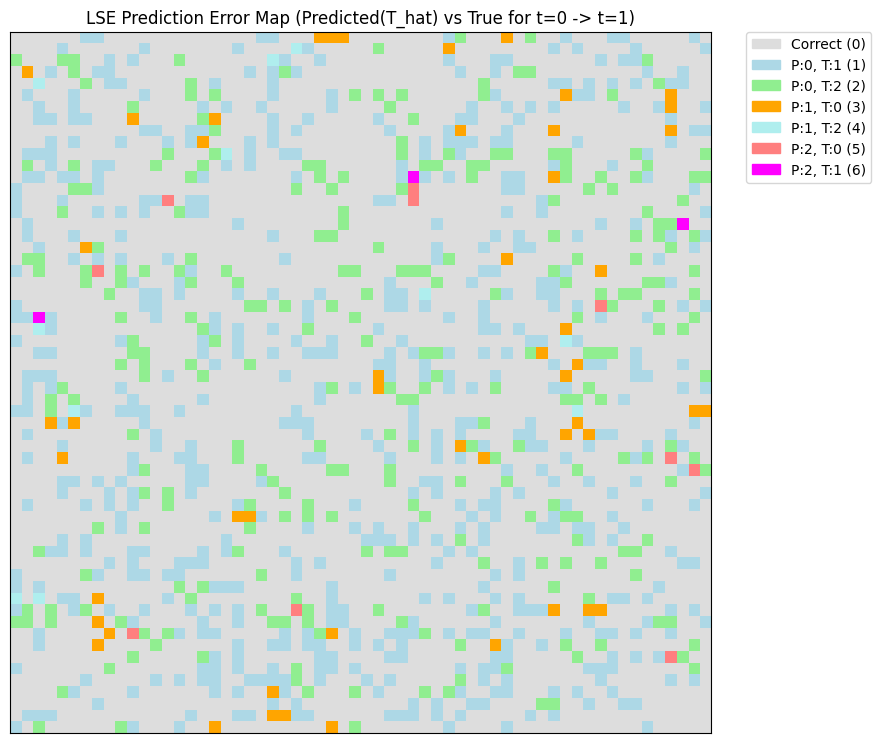


Script finished.


In [ ]:
if __name__ == "__main__":
    GRID_SIZE_X, GRID_SIZE_Y = 60, 60
    NUM_STEPS = 1
    INITIAL_DENSITY_A = 0.2
    INITIAL_DENSITY_B = 0.1
    K_states = 3
    LSE_STRIDE = 3

    T_true = np.array([
        [1.0, 0.0, 0.0], # Dead -> (Dead, A, B)
        [0.125, 0.875, 0], # A    -> (Dead, A, B)
        [0, 0.192, 0.808]  # B    -> (Dead, A, B)
    ])
    # T_true = T_true / T_true.sum(axis=1, keepdims=True) # This is manually set anyway

    SIMULATION_TAG = "my_pca_2d_3state_eval_run_nonoverlap_baseline"
    OUTPUT_BASE_DIR = "output_pca_2d_3state"
    OUTPUT_FRAMES_DIR = os.path.join(OUTPUT_BASE_DIR, SIMULATION_TAG, "frames")
    OUTPUT_STATES_DIR = os.path.join(OUTPUT_BASE_DIR, SIMULATION_TAG, "states")

    pca_game = ProbabilisticGOL2D_3State(
        grid_size_x=GRID_SIZE_X,
        grid_size_y=GRID_SIZE_Y,
        local_transition_matrix=T_true
    )

    # fix seed
    np.random.seed(123)
    random.seed(123)
    pca_game.randomize(density_a=INITIAL_DENSITY_A, density_b=INITIAL_DENSITY_B)

    history = run_pca_2d_and_save(
        pca_instance=pca_game,
        num_steps=NUM_STEPS, # Should be 1
        frames_dir=OUTPUT_FRAMES_DIR,
        states_dir=OUTPUT_STATES_DIR,
        base_filename_tag=SIMULATION_TAG
    )

    T_estimated_lse = run_lse_inference( # Renamed variable for clarity
        states_dir=OUTPUT_STATES_DIR,
        base_filename_tag=SIMULATION_TAG,
        K_states=K_states,
        use_non_overlapping=True,
        stride=LSE_STRIDE
    )

    T_baseline = None
    if len(history) >= 2:
        print("\nCalculating Baseline T matrix (T_base)...")
        T_baseline = calculate_baseline_T(
            grid_t=history[0],       # State at t=0
            grid_t_plus_1=history[1], # State at t=1
            K_states=K_states
        )
    else:
         print("\nSkipping Baseline T calculation: Not enough history.")

    if len(history) >= 2:
        # Check if LSE estimation succeeded before passing it
        evaluate_estimation(
            T_true=T_true,
            T_estimated_lse=T_estimated_lse,
            T_baseline=T_baseline,
            grid_0=history[0],
            grid_1=history[1]
        )
        plt.show()
    elif len(history) < 2:
         print("need t=0 and t=1, lacking histroy")
    else:
         # This case implies history was generated, but maybe LSE failed?
         # Or handle based on whether T_baseline was calculated.
         print("LSE or Baseline estimation fail")

    print("\nScript finished.")

In [ ]:
def calculate_accuracy(T_est, T_true, grid_0, grid_1, is_baseline=False):
    """ Calculates prediction accuracy for a given estimated T matrix. """
    if T_est is None: return -1.0 # Indicate failure
    K_states = T_true.shape[0]
    rows, cols = grid_0.shape
    total_cells = grid_0.size
    correct_predictions = 0
    if total_cells == 0: return -1.0

    temp_pca = None
    if not is_baseline:
         temp_pca = ProbabilisticGOL2D_3State(rows, cols, T_est)

    for i in range(rows):
        for j in range(cols):
            start_state = grid_0[i, j]
            true_next_state = grid_1[i, j]

            if not (0 <= start_state < K_states and 0 <= true_next_state < K_states):
                continue

            if is_baseline:
                pred_prob_vector = T_est[start_state, :]
            else:
                # LSE prediction uses neighborhood info (phi) and T_hat
                n_s0, n_s1, n_s2, n_neigh = num_neigh_states(grid_0, i, j)
                pred_prob_vector = temp_pca._calculate_prob_vector(n_s0, n_s1, n_s2, n_neigh)

            # Determine the most likely next state
            predicted_state = np.argmax(pred_prob_vector)

            # Check if the prediction matches the actual next state
            if predicted_state == true_next_state:
                correct_predictions += 1

    # Return accuracy percentage
    return (correct_predictions / total_cells) * 100 if total_cells > 0 else 0.0

In [ ]:
def power_law(x, a, b):
    # Ensure x is positive for power law fits
    x = np.maximum(x, 1e-9) # Add small epsilon
    return a * x**b

# Consistency

In [ ]:
import shutil

def consistency_analysis_over_sample_sizes(
    T_true, grid_size_list, num_trials_per_size=5,
    initial_density_a=0.2, initial_density_b=0.1, num_steps=1,
    K_states=3, stride=3
):
    """
    Runs consistency tests over increasing grid sizes and returns statistics for T_lse and T_base
    """
    # Lists to store average metrics per size
    lse_avg_errors = []
    baseline_avg_errors = []
    lse_accuracies = []
    baseline_accuracies = []
    lse_bias_sq_list = []
    baseline_bias_sq_list = []
    lse_variance_list = []
    baseline_variance_list = []
    sample_sizes = [] # N_samples = (grid_size // stride)**2
    avg_runtimes = []

    for grid_size in grid_size_list:
        print(f"\n===== Grid size: {grid_size}x{grid_size} =====")
        trial_T_hat_lse_list = []
        trial_T_hat_baseline_list = []
        trial_lse_errors_sq = [] # Store squared errors for MSE calculation
        trial_baseline_errors_sq = []
        trial_lse_accuracies = []
        trial_baseline_accuracies = []
        trial_runtimes = []

        for trial in range(num_trials_per_size):
            print(f"--- Trial {trial+1}/{num_trials_per_size} ---")
            start_time_trial = time.time()
            sim_tag = f"consistency_run_{grid_size}_{trial}"
            # Use unique temp dirs per trial to avoid conflicts if run in parallel
            base_temp_dir = f"temp_consistency_{grid_size}_{trial}"
            frames_dir = os.path.join(base_temp_dir, "frames")
            states_dir = os.path.join(base_temp_dir, "states")

            pca = ProbabilisticGOL2D_3State(grid_size, grid_size, T_true)
            np.random.seed(trial * grid_size + grid_size) # Vary seed more
            random.seed(trial * grid_size + grid_size)
            pca.randomize(density_a=initial_density_a, density_b=initial_density_b)

            history = run_pca_2d_and_save(
                pca_instance=pca, num_steps=max(1, num_steps), # aT Least 1 step
                frames_dir=frames_dir, states_dir=states_dir,
                base_filename_tag=sim_tag
            )

            if len(history) < 2:
                print("Error: Simulation did not produce enough steps. Skipping trial.")
                if os.path.exists(base_temp_dir): shutil.rmtree(base_temp_dir)
                continue

            grid_0, grid_1 = history[0], history[1]

            # LSE Inference
            T_hat_lse = run_lse_inference(
                states_dir=states_dir, base_filename_tag=sim_tag, K_states=K_states,
                use_non_overlapping=True, stride=stride
            )

            # Baseline Inference
            T_hat_baseline = calculate_baseline_T(grid_0, grid_1, K_states)

            if T_hat_lse is not None:
                trial_T_hat_lse_list.append(T_hat_lse)
                trial_lse_errors_sq.append(np.linalg.norm(T_true - T_hat_lse, 'fro')**2)
            if T_hat_baseline is not None:
                trial_T_hat_baseline_list.append(T_hat_baseline)
                trial_baseline_errors_sq.append(np.linalg.norm(T_true - T_hat_baseline, 'fro')**2)

            acc_lse = calculate_accuracy(T_hat_lse, T_true, grid_0, grid_1, is_baseline=False)
            acc_base = calculate_accuracy(T_hat_baseline, T_true, grid_0, grid_1, is_baseline=True)
            trial_lse_accuracies.append(acc_lse)
            trial_baseline_accuracies.append(acc_base)

            elapsed_trial = time.time() - start_time_trial
            trial_runtimes.append(elapsed_trial)

            acc_diff = acc_lse - acc_base if acc_lse >= 0 and acc_base >= 0 else float('nan')
            print(f"Trial {trial+1} completed in {elapsed_trial:.2f}s | Acc LSE: {acc_lse:.2f}% | Acc Base: {acc_base:.2f}% | Diff: {acc_diff:+.2f}%")

            if os.path.exists(base_temp_dir):
                try: shutil.rmtree(base_temp_dir)
                except OSError as e: print(f"Warning: Could not remove temp dir {base_temp_dir}: {e}")


        # Statistics for this grid size
        avg_lse_err, avg_base_err = np.nan, np.nan
        avg_lse_acc, avg_base_acc = np.nan, np.nan
        bias_sq_lse, bias_sq_base = np.nan, np.nan
        variance_lse, variance_base = np.nan, np.nan
        eff_sample_size = (grid_size // stride)**2
        avg_rt = np.nan

        if trial_T_hat_lse_list: # Check if any LSE trials succeeded
            # LSE Metrics
            valid_lse_trials = np.array(trial_T_hat_lse_list)
            avg_T_lse = np.mean(valid_lse_trials, axis=0)
            bias_sq_lse = np.linalg.norm(avg_T_lse - T_true, 'fro')**2
            mse_lse = np.mean(trial_lse_errors_sq)
            variance_lse = max(0.0, mse_lse - bias_sq_lse) # Variance = MSE - Bias^2
            avg_lse_err = np.sqrt(mse_lse)
            avg_lse_acc = np.mean([a for a in trial_lse_accuracies if a >= 0])

        if trial_T_hat_baseline_list:
            # Baseline Metrics
            valid_baseline_trials = np.array(trial_T_hat_baseline_list)
            avg_T_base = np.mean(valid_baseline_trials, axis=0)
            bias_sq_base = np.linalg.norm(avg_T_base - T_true, 'fro')**2
            mse_base = np.mean(trial_baseline_errors_sq)
            variance_base = max(0.0, mse_base - bias_sq_base)
            avg_base_err = np.sqrt(mse_base)
            avg_base_acc = np.mean([a for a in trial_baseline_accuracies if a >= 0])

        if trial_runtimes:
            avg_rt = np.mean(trial_runtimes)

        lse_avg_errors.append(avg_lse_err)
        baseline_avg_errors.append(avg_base_err)
        lse_accuracies.append(avg_lse_acc)
        baseline_accuracies.append(avg_base_acc)
        lse_bias_sq_list.append(bias_sq_lse)
        baseline_bias_sq_list.append(bias_sq_base)
        lse_variance_list.append(variance_lse)
        baseline_variance_list.append(variance_base)
        sample_sizes.append(eff_sample_size)
        avg_runtimes.append(avg_rt)

        print(f"\nGrid Size {grid_size}x{grid_size} Averages ({num_trials_per_size} trials):")
        print(f"  Avg LSE Frobenius Error (sqrt(MSE)): {avg_lse_err:.4f}")
        print(f"  Avg LSE Bias^2: {bias_sq_lse:.4e}")
        print(f"  Avg LSE Variance: {variance_lse:.4e}")
        print(f"  Avg LSE Accuracy: {avg_lse_acc:.2f}%")
        print(f"  Avg Baseline Frobenius Error (sqrt(MSE)): {avg_base_err:.4f}")
        print(f"  Avg Baseline Bias^2: {bias_sq_base:.4e}")
        print(f"  Avg Baseline Variance: {variance_base:.4e}")
        print(f"  Avg Baseline Accuracy: {avg_base_acc:.2f}%")
        print(f"  Avg Runtime per trial: {avg_rt:.2f} seconds")

    return (sample_sizes,
            lse_avg_errors, baseline_avg_errors,
            lse_accuracies, baseline_accuracies,
            lse_bias_sq_list, baseline_bias_sq_list,
            lse_variance_list, baseline_variance_list,
            avg_runtimes)

Streaming output truncated to the last 5000 lines.
Step 1/1 | Counts: D=168, A=34, B=23  | P(t-1 -> t): 2.689e-62      
Simulation run 'consistency_run_15_2' finished.
   ffmpeg -framerate 10 -i "temp_consistency_15_2/frames/consistency_run_15_2_frame_%04d.png" -c:v libx264 -pix_fmt yuv420p "consistency_run_15_2_video.mp4"

--- Starting LSE Inference ---
Found 2 state files. Processing 1 transitions for LSE.
Processing transition: consistency_run_15_2_state_0000.txt -> consistency_run_15_2_state_0001.txt
Using non-overlapping extraction with stride 3...

Total data points collected for LSE: 25

Total data points for LSE: 25
Building normal matrices A and B...
Normal Matrix A:
[[0.516875 0.12125  0.056875]
 [0.12125  0.078125 0.015625]
 [0.056875 0.015625 0.0175  ]]

Normal Vector Matrix B:
[[0.565 0.045 0.085]
 [0.13  0.065 0.02 ]
 [0.065 0.01  0.015]]

Solving for estimated local transition matrix T_hat...

Estimated Local Transition Matrix (T_hat Raw):
[[ 1.07883953 -0.19270065  0.11

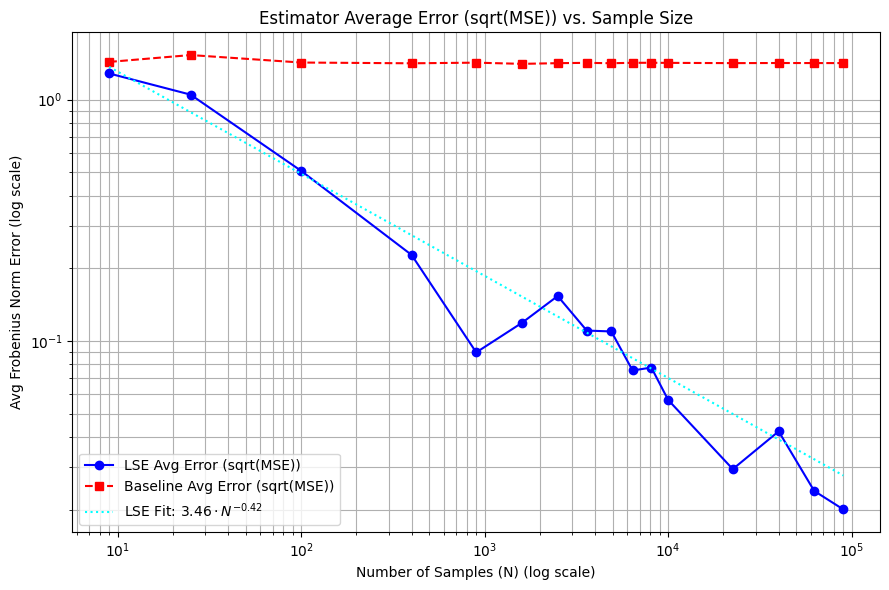

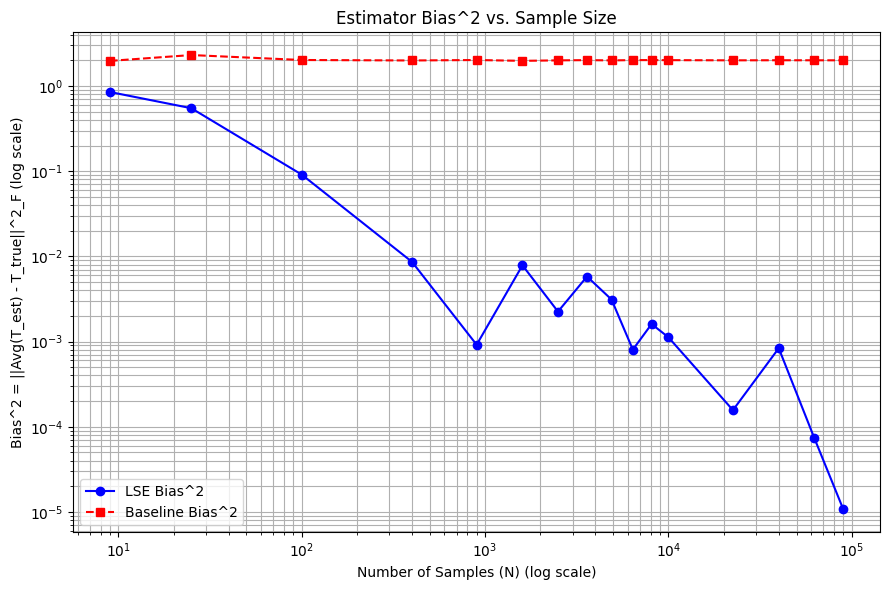

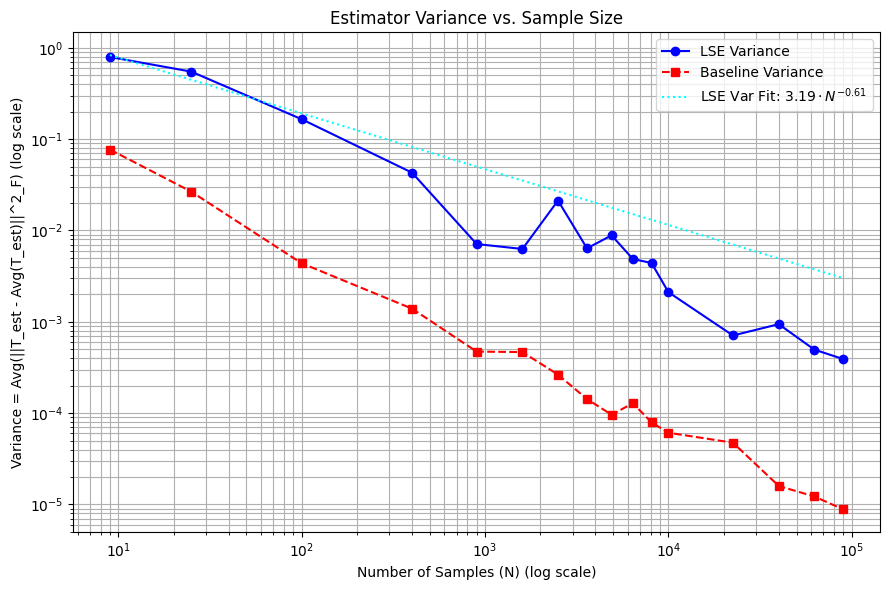

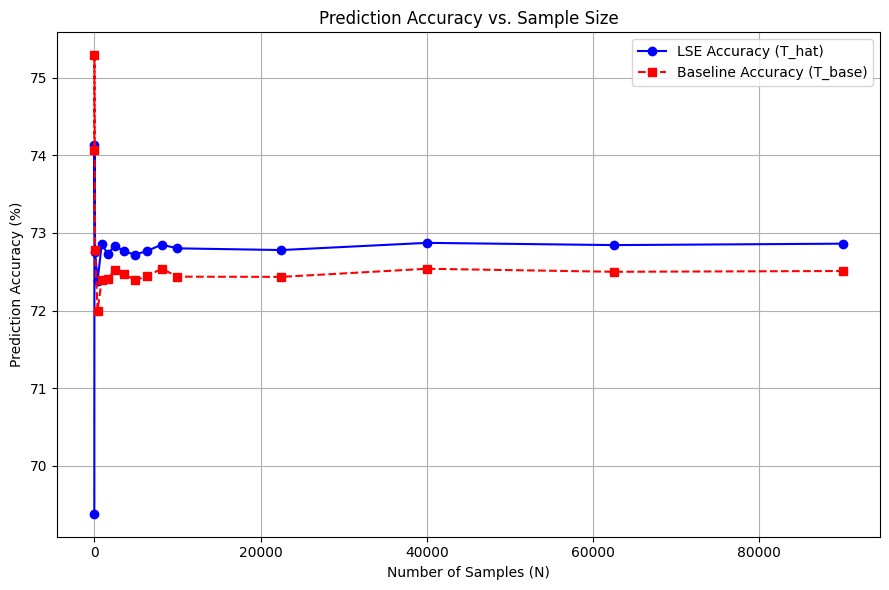

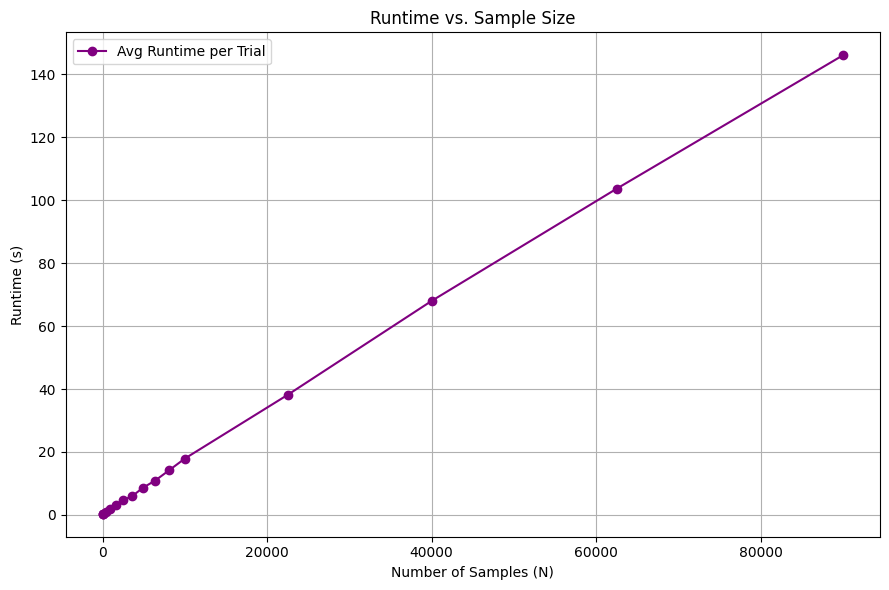


Script finished.


In [ ]:
if __name__ == "__main__":
    T_true = np.array([
        [1.0, 0.0, 0.0],    # Dead -> (Dead, A, B)
        [0.125, 0.875, 0.0],# A    -> (Dead, A, B)
        [0.0, 0.192, 0.808] # B    -> (Dead, A, B)
    ])
    T_true = T_true / T_true.sum(axis=1, keepdims=True) # Ensure stochastic

    grid_sizes_to_test = [9, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 450, 600, 750, 900]
    NUM_TRIALS = 5
    LSE_STRIDE = 3
    K_states = 3

    results = consistency_analysis_over_sample_sizes(
        T_true=T_true,
        grid_size_list=grid_sizes_to_test,
        num_trials_per_size=NUM_TRIALS,
        stride=LSE_STRIDE,
        K_states=K_states
    )
    (sample_sizes, lse_errors, baseline_errors, lse_accuracies, baseline_accuracies,
     lse_bias_sq, baseline_bias_sq, lse_variances, baseline_variances, avg_runtimes) = results

    if sample_sizes:
        sample_sizes = np.array(sample_sizes)
        lse_errors = np.array(lse_errors); baseline_errors = np.array(baseline_errors)
        lse_accuracies = np.array(lse_accuracies); baseline_accuracies = np.array(baseline_accuracies)
        lse_bias_sq = np.array(lse_bias_sq); baseline_bias_sq = np.array(baseline_bias_sq)
        lse_variances = np.array(lse_variances); baseline_variances = np.array(baseline_variances)
        avg_runtimes = np.array(avg_runtimes)

        valid_mask = ~np.isnan(lse_errors) & ~np.isnan(baseline_errors) & \
                     ~np.isnan(lse_accuracies) & ~np.isnan(baseline_accuracies) & \
                     ~np.isnan(lse_bias_sq) & ~np.isnan(baseline_bias_sq) & \
                     ~np.isnan(lse_variances) & ~np.isnan(baseline_variances) & \
                     ~np.isnan(avg_runtimes)

        if np.any(valid_mask):
            sample_sizes_valid = sample_sizes[valid_mask]
            lse_errors_valid = lse_errors[valid_mask]; baseline_errors_valid = baseline_errors[valid_mask]
            lse_accuracies_valid = lse_accuracies[valid_mask]; baseline_accuracies_valid = baseline_accuracies[valid_mask]
            lse_bias_sq_valid = lse_bias_sq[valid_mask]; baseline_bias_sq_valid = baseline_bias_sq[valid_mask]
            lse_variances_valid = lse_variances[valid_mask]; baseline_variances_valid = baseline_variances[valid_mask]
            avg_runtimes_valid = avg_runtimes[valid_mask]

            # Average Frobenius error = sqrt(MSE) (Log-Log scale)
            plt.figure(figsize=(9, 6))
            plt.plot(sample_sizes_valid, lse_errors_valid, 'o-', color='blue', label='LSE Avg Error (sqrt(MSE))')
            plt.plot(sample_sizes_valid, baseline_errors_valid, 's--', color='red', label='Baseline Avg Error (sqrt(MSE))') # Added Baseline Error
            try: # Fit power law to LSE error
                popt_lse, _ = curve_fit(power_law, sample_sizes_valid, lse_errors_valid, p0=[1.0, -0.5], maxfev=5000)
                sizes_fit = np.geomspace(min(sample_sizes_valid), max(sample_sizes_valid), 100)
                errors_fit_lse = power_law(sizes_fit, *popt_lse)
                plt.plot(sizes_fit, errors_fit_lse, ':', color='cyan', label=f'LSE Fit: ${popt_lse[0]:.2f} \\cdot N^{{{popt_lse[1]:.2f}}}$')
            except Exception as e: print(f"Could not fit power law to LSE error: {e}")
            plt.xscale('log'); plt.yscale('log'); plt.xlabel('Number of Samples (N) (log scale)'); plt.ylabel('Avg Frobenius Norm Error (log scale)')
            plt.title('Estimator Average Error (sqrt(MSE)) vs. Sample Size'); plt.grid(True, which='both'); plt.legend(); plt.tight_layout(); plt.show()

            # Plot Bias Squared (Log-Log scale)
            plt.figure(figsize=(9, 6))
            plt.plot(sample_sizes_valid, lse_bias_sq_valid, 'o-', color='blue', label='LSE Bias^2')
            plt.plot(sample_sizes_valid, baseline_bias_sq_valid, 's--', color='red', label='Baseline Bias^2')
            plt.xscale('log'); plt.yscale('log'); plt.xlabel('Number of Samples (N) (log scale)'); plt.ylabel('Bias^2 = ||Avg(T_est) - T_true||^2_F (log scale)')
            plt.title('Estimator Bias^2 vs. Sample Size'); plt.grid(True, which='both'); plt.legend(); plt.tight_layout(); plt.show()

            # Plot Variance (Log-Log scale)
            plt.figure(figsize=(9, 6))
            plt.plot(sample_sizes_valid, lse_variances_valid, 'o-', color='blue', label='LSE Variance')
            plt.plot(sample_sizes_valid, baseline_variances_valid, 's--', color='red', label='Baseline Variance')
            try: # Fit power law to LSE variance
                pos_var_mask = lse_variances_valid > 1e-12 # Ensure positive values for log fitting
                if np.any(pos_var_mask):
                    popt_var, _ = curve_fit(power_law, sample_sizes_valid[pos_var_mask], lse_variances_valid[pos_var_mask], p0=[1.0, -1.0], maxfev=5000)
                    sizes_fit_var = np.geomspace(min(sample_sizes_valid[pos_var_mask]), max(sample_sizes_valid[pos_var_mask]), 100)
                    variances_fit_lse = power_law(sizes_fit_var, *popt_var)
                    plt.plot(sizes_fit_var, variances_fit_lse, ':', color='cyan', label=f'LSE Var Fit: ${popt_var[0]:.2f} \\cdot N^{{{popt_var[1]:.2f}}}$')
                else: print("No positive variance data to fit power law.")
            except Exception as e: print(f"Could not fit power law to LSE variance: {e}")
            plt.xscale('log'); plt.yscale('log'); plt.xlabel('Number of Samples (N) (log scale)'); plt.ylabel('Variance = Avg(||T_est - Avg(T_est)||^2_F) (log scale)')
            plt.title('Estimator Variance vs. Sample Size'); plt.grid(True, which='both'); plt.legend(); plt.tight_layout(); plt.show()

            # 4. Plot Prediction Accuracy (Linear scale)
            plt.figure(figsize=(9, 6))
            plt.plot(sample_sizes_valid, lse_accuracies_valid, 'o-', color='blue', label='LSE Accuracy (T_hat)')
            plt.plot(sample_sizes_valid, baseline_accuracies_valid, 's--', color='red', label='Baseline Accuracy (T_base)')
            plt.xlabel('Number of Samples (N)'); plt.ylabel('Prediction Accuracy (%)'); plt.title('Prediction Accuracy vs. Sample Size')
            plt.grid(True);
            plt.legend(); plt.tight_layout(); plt.show()

            # Linear scale for x, Log or Linear for y
            plt.figure(figsize=(9, 6))
            plt.plot(sample_sizes_valid, avg_runtimes_valid, 'o-', color='purple', label='Avg Runtime per Trial')
            plt.xlabel('Number of Samples (N)'); plt.ylabel('Runtime (s)'); plt.title('Runtime vs. Sample Size')
            plt.grid(True, which='both'); plt.legend(); plt.tight_layout(); plt.show()

        else:
            print("Consistency analysis did not produce valid results for plotting.")
    else:
        print("Consistency analysis did not produce results.")

    print("\nScript finished.")

Streaming output truncated to the last 5000 lines.
Calculated T_base (Before final normalization check):
[[0.71706349 0.19761905 0.08531746]
 [0.7125     0.20277778 0.08472222]
 [0.73333333 0.18611111 0.08055556]]
Final Baseline Transition Matrix (T_base):
[[0.71706349 0.19761905 0.08531746]
 [0.7125     0.20277778 0.08472222]
 [0.73333333 0.18611111 0.08055556]]
Initialized 3-state probabilistic grid with shape: (60, 60)
Using Local Transition Matrix T:
[[1.         0.         0.        ]
 [0.         0.90699388 0.09300612]
 [0.         0.17038669 0.82961331]]
Trial 6 completed in 0.81s | Acc LSE: 71.50% | Acc Base: 71.78% | Diff: -0.28%
--- Trial 7/10 ---
Initialized 3-state probabilistic grid with shape: (60, 60)
Using Local Transition Matrix T:
[[1.    0.    0.   ]
 [0.125 0.875 0.   ]
 [0.    0.192 0.808]]
Randomized grid: ~20.0% Type A, ~10.0% Type B.

Starting 3-state 2D PCA run 'consistency_run_60_6' for 1 steps...
Output frames to: temp_consistency_60_6/frames
Output states to

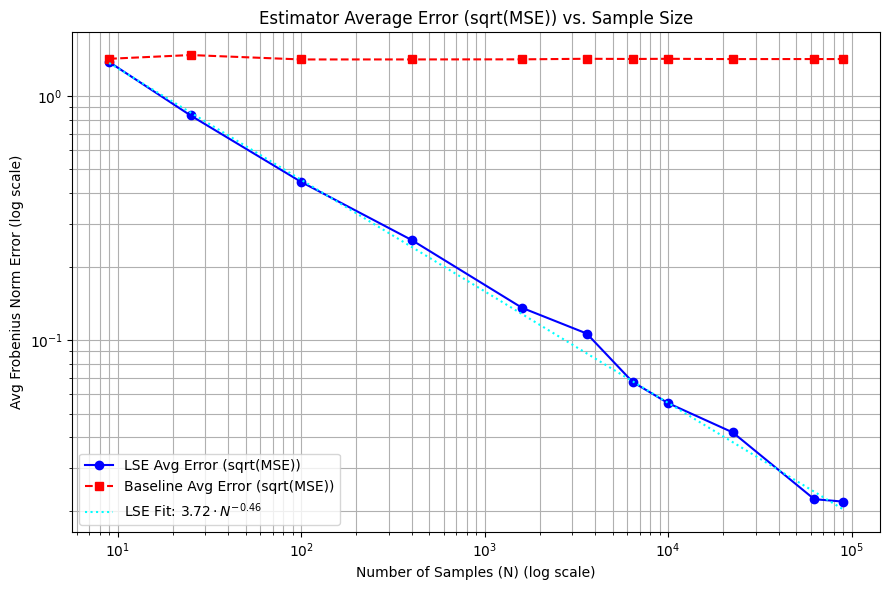

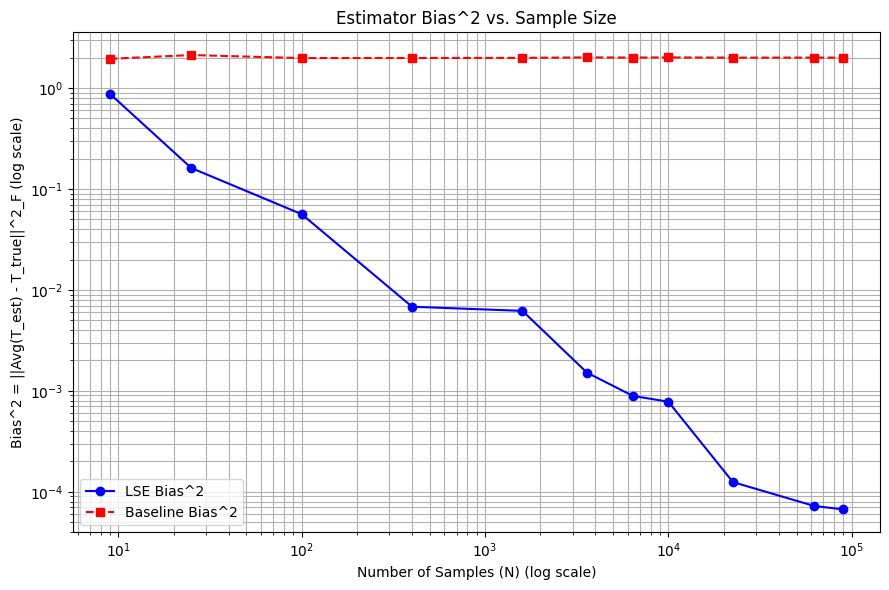

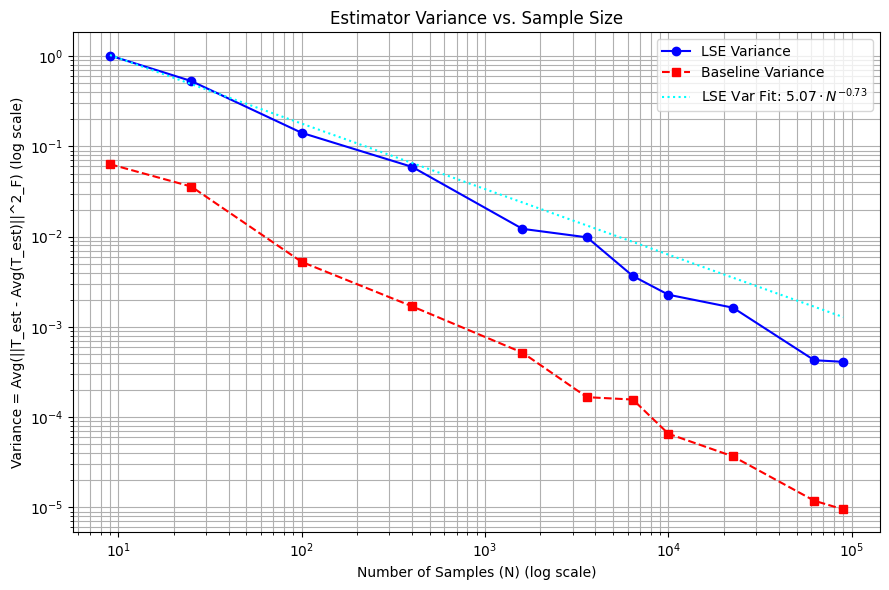

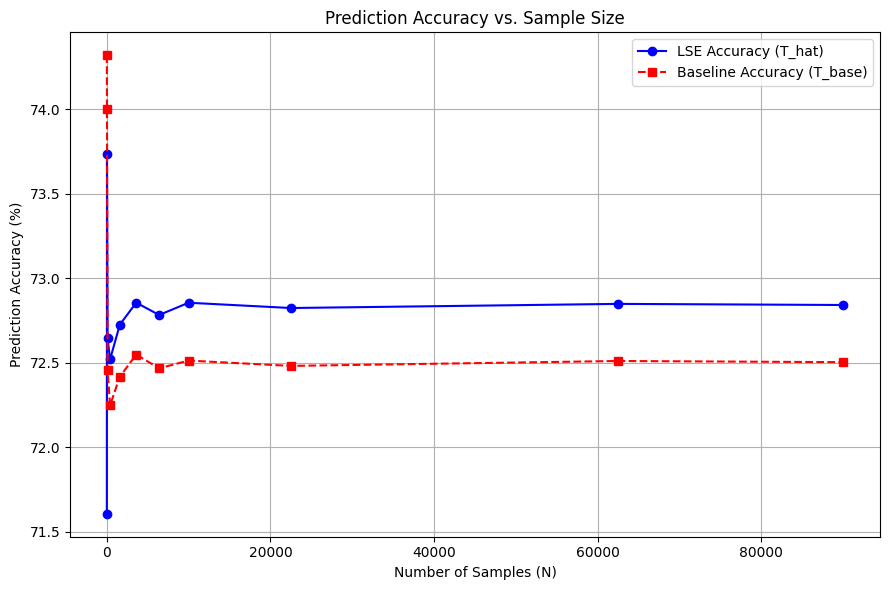

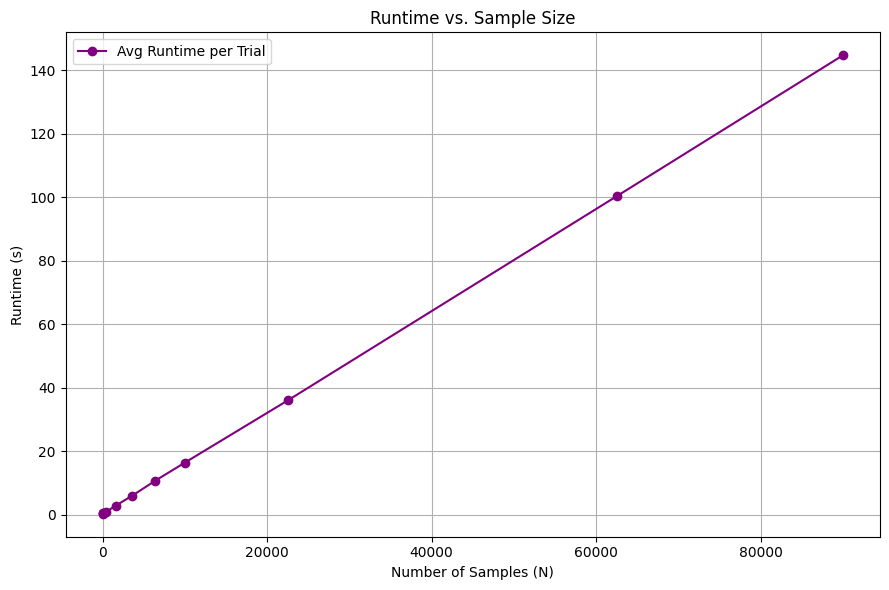


Script finished.


In [ ]:
if __name__ == "__main__":
    T_true = np.array([
        [1.0, 0.0, 0.0],    # Dead -> (Dead, A, B)
        [0.125, 0.875, 0.0],# A    -> (Dead, A, B)
        [0.0, 0.192, 0.808] # B    -> (Dead, A, B)
    ])
    T_true = T_true / T_true.sum(axis=1, keepdims=True) # Ensure stochastic

    grid_sizes_to_test = [9, 15, 30, 60, 120, 180, 240, 300, 450, 750, 900]
    NUM_TRIALS = 10
    LSE_STRIDE = 3
    K_states = 3

    results = consistency_analysis_over_sample_sizes(
        T_true=T_true,
        grid_size_list=grid_sizes_to_test,
        num_trials_per_size=NUM_TRIALS,
        stride=LSE_STRIDE,
        K_states=K_states
    )
    (sample_sizes, lse_errors, baseline_errors, lse_accuracies, baseline_accuracies,
     lse_bias_sq, baseline_bias_sq, lse_variances, baseline_variances, avg_runtimes) = results

    if sample_sizes:
        sample_sizes = np.array(sample_sizes)
        lse_errors = np.array(lse_errors); baseline_errors = np.array(baseline_errors)
        lse_accuracies = np.array(lse_accuracies); baseline_accuracies = np.array(baseline_accuracies)
        lse_bias_sq = np.array(lse_bias_sq); baseline_bias_sq = np.array(baseline_bias_sq)
        lse_variances = np.array(lse_variances); baseline_variances = np.array(baseline_variances)
        avg_runtimes = np.array(avg_runtimes)

        valid_mask = ~np.isnan(lse_errors) & ~np.isnan(baseline_errors) & \
                     ~np.isnan(lse_accuracies) & ~np.isnan(baseline_accuracies) & \
                     ~np.isnan(lse_bias_sq) & ~np.isnan(baseline_bias_sq) & \
                     ~np.isnan(lse_variances) & ~np.isnan(baseline_variances) & \
                     ~np.isnan(avg_runtimes)

        if np.any(valid_mask):
            sample_sizes_valid = sample_sizes[valid_mask]
            lse_errors_valid = lse_errors[valid_mask]; baseline_errors_valid = baseline_errors[valid_mask]
            lse_accuracies_valid = lse_accuracies[valid_mask]; baseline_accuracies_valid = baseline_accuracies[valid_mask]
            lse_bias_sq_valid = lse_bias_sq[valid_mask]; baseline_bias_sq_valid = baseline_bias_sq[valid_mask]
            lse_variances_valid = lse_variances[valid_mask]; baseline_variances_valid = baseline_variances[valid_mask]
            avg_runtimes_valid = avg_runtimes[valid_mask]

            # Plot Average Frobenius error = sqrt(MSE) (Log-Log scale)
            plt.figure(figsize=(9, 6))
            plt.plot(sample_sizes_valid, lse_errors_valid, 'o-', color='blue', label='LSE Avg Error (sqrt(MSE))')
            plt.plot(sample_sizes_valid, baseline_errors_valid, 's--', color='red', label='Baseline Avg Error (sqrt(MSE))') # Added Baseline Error
            try: # Fit power law to LSE error
                popt_lse, _ = curve_fit(power_law, sample_sizes_valid, lse_errors_valid, p0=[1.0, -0.5], maxfev=5000)
                sizes_fit = np.geomspace(min(sample_sizes_valid), max(sample_sizes_valid), 100)
                errors_fit_lse = power_law(sizes_fit, *popt_lse)
                plt.plot(sizes_fit, errors_fit_lse, ':', color='cyan', label=f'LSE Fit: ${popt_lse[0]:.2f} \\cdot N^{{{popt_lse[1]:.2f}}}$')
            except Exception as e: print(f"Could not fit power law to LSE error: {e}")
            plt.xscale('log'); plt.yscale('log'); plt.xlabel('Number of Samples (N) (log scale)'); plt.ylabel('Avg Frobenius Norm Error (log scale)')
            plt.title('Estimator Average Error (sqrt(MSE)) vs. Sample Size'); plt.grid(True, which='both'); plt.legend(); plt.tight_layout(); plt.show()

            # Bias Squared (Log-Log scale)
            plt.figure(figsize=(9, 6))
            plt.plot(sample_sizes_valid, lse_bias_sq_valid, 'o-', color='blue', label='LSE Bias^2')
            plt.plot(sample_sizes_valid, baseline_bias_sq_valid, 's--', color='red', label='Baseline Bias^2')
            plt.xscale('log'); plt.yscale('log'); plt.xlabel('Number of Samples (N) (log scale)'); plt.ylabel('Bias^2 = ||Avg(T_est) - T_true||^2_F (log scale)')
            plt.title('Estimator Bias^2 vs. Sample Size'); plt.grid(True, which='both'); plt.legend(); plt.tight_layout(); plt.show()

            # Variance (Log-Log scale)
            plt.figure(figsize=(9, 6))
            plt.plot(sample_sizes_valid, lse_variances_valid, 'o-', color='blue', label='LSE Variance')
            plt.plot(sample_sizes_valid, baseline_variances_valid, 's--', color='red', label='Baseline Variance')
            try: # Fit power law to LSE variance
                pos_var_mask = lse_variances_valid > 1e-12 # Ensure positive values for log fitting
                if np.any(pos_var_mask):
                    popt_var, _ = curve_fit(power_law, sample_sizes_valid[pos_var_mask], lse_variances_valid[pos_var_mask], p0=[1.0, -1.0], maxfev=5000)
                    sizes_fit_var = np.geomspace(min(sample_sizes_valid[pos_var_mask]), max(sample_sizes_valid[pos_var_mask]), 100)
                    variances_fit_lse = power_law(sizes_fit_var, *popt_var)
                    plt.plot(sizes_fit_var, variances_fit_lse, ':', color='cyan', label=f'LSE Var Fit: ${popt_var[0]:.2f} \\cdot N^{{{popt_var[1]:.2f}}}$')
                else: print("No positive variance data to fit power law.")
            except Exception as e: print(f"Could not fit power law to LSE variance: {e}")
            plt.xscale('log'); plt.yscale('log'); plt.xlabel('Number of Samples (N) (log scale)'); plt.ylabel('Variance = Avg(||T_est - Avg(T_est)||^2_F) (log scale)')
            plt.title('Estimator Variance vs. Sample Size'); plt.grid(True, which='both'); plt.legend(); plt.tight_layout(); plt.show()

            plt.figure(figsize=(9, 6))
            plt.plot(sample_sizes_valid, lse_accuracies_valid, 'o-', color='blue', label='LSE Accuracy (T_hat)')
            plt.plot(sample_sizes_valid, baseline_accuracies_valid, 's--', color='red', label='Baseline Accuracy (T_base)')
            plt.xlabel('Number of Samples (N)'); plt.ylabel('Prediction Accuracy (%)'); plt.title('Prediction Accuracy vs. Sample Size')
            plt.grid(True);
            plt.legend(); plt.tight_layout(); plt.show()

            plt.figure(figsize=(9, 6))
            plt.plot(sample_sizes_valid, avg_runtimes_valid, 'o-', color='purple', label='Avg Runtime per Trial')
            plt.xlabel('Number of Samples (N)'); plt.ylabel('Runtime (s)'); plt.title('Runtime vs. Sample Size')
            plt.grid(True, which='both'); plt.legend(); plt.tight_layout(); plt.show()

        else:
            print("Consistency analysis did not produce valid results for plotting.")
    else:
        print("Consistency analysis did not produce results.")

    print("\nScript finished.")